# Model Training

In diesem Notebook trainieren wir neuronale Netze zur Werkzeug-Erkennung. Die Daten wurden bereits im Schritt [Objektextraktion](semester-arbeit-objekt-abstraktion.ipynb) extrahiert und in ZIP-Dateien (`training_Baumstruktur.zip` und `testing_Baumstruktur.zip`) gespeichert.

Zunächst entpacken wir die bereits erstellten ZIP-Dateien mit der Baumstruktur. Die Objektbilder wurden bereits extrahiert und in Train- und Test-Ordner aufgeteilt. 

In [ ]:
# ============================================================================
# ALLE IMPORTS - Diese Zelle muss zuerst ausgeführt werden!
# ============================================================================
# Standard-Bibliotheken
import zipfile
import os
import sys
import subprocess
from pathlib import Path
from collections import Counter

# Wissenschaftliche Bibliotheken
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'  # Reduziere TensorFlow-Logging

# Scikit-learn (für Metriken)
from sklearn.metrics import confusion_matrix, classification_report

# Seaborn (optional, für bessere Visualisierungen)
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("⚠ seaborn nicht verfügbar, verwende matplotlib")

# Scikit-plot (optional, für Confusion Matrix)
try:
    import scikitplot as skplt
    HAS_SCIKIT_PLOT = True
except ImportError:
    HAS_SCIKIT_PLOT = False
    print("⚠ scikit-plot nicht verfügbar, verwende sklearn.metrics + seaborn")

# Eigene Scripts aus scripts-Ordner
scripts_path = Path('scripts')
if scripts_path.exists():
    if str(scripts_path.absolute()) not in sys.path:
        sys.path.insert(0, str(scripts_path.absolute()))

# Importiere die Funktionen einzeln, um zu sehen welche fehlschlagen
imported_functions = {}

try:
    from model_transfer_learning import make_model_transfer_learning
    imported_functions['make_model_transfer_learning'] = make_model_transfer_learning
    print("✓ make_model_transfer_learning importiert")
except ImportError as e:
    print(f"⚠ make_model_transfer_learning konnte nicht importiert werden: {e}")

try:
    from model_simple_cnn import make_model_simple_cnn
    imported_functions['make_model_simple_cnn'] = make_model_simple_cnn
    print("✓ make_model_simple_cnn importiert")
except ImportError as e:
    print(f"⚠ make_model_simple_cnn konnte nicht importiert werden: {e}")

try:
    from train_simple_cnn import train_simple_cnn
    imported_functions['train_simple_cnn'] = train_simple_cnn
    print("✓ train_simple_cnn importiert")
except ImportError as e:
    print(f"⚠ train_simple_cnn konnte nicht importiert werden: {e}")

try:
    from train_transfer_learning import train_transfer_learning
    imported_functions['train_transfer_learning'] = train_transfer_learning
    print("✓ train_transfer_learning importiert")
except ImportError as e:
    print(f"⚠ train_transfer_learning konnte nicht importiert werden: {e}")

try:
    from train_standard import train_standard
    imported_functions['train_standard'] = train_standard
    print("✓ train_standard importiert")
except ImportError as e:
    print(f"⚠ train_standard konnte nicht importiert werden: {e}")

try:
    from evaluate_model import full_evaluation, plot_training_history
    imported_functions['full_evaluation'] = full_evaluation
    imported_functions['plot_training_history'] = plot_training_history
    print("✓ full_evaluation und plot_training_history importiert")
except ImportError as e:
    print(f"⚠ evaluate_model Funktionen konnten nicht importiert werden: {e}")

if len(imported_functions) > 0:
    print(f"\n✓ {len(imported_functions)} Funktion(en) erfolgreich importiert")
else:
    print("\n❌ Keine Funktionen konnten importiert werden!")

print("\n✓ Alle Imports abgeschlossen!")
print(f"  - TensorFlow Version: {tf.__version__}")
print(f"  - NumPy Version: {np.__version__}")
print(f"  - GPU verfügbar: {len(tf.config.list_physical_devices('GPU')) > 0}")

# ============================================================================
# ENTPACKE DIE ZIP-DATEIEN MIT DER BAUMSTRUKTUR
# ============================================================================

# Pfad für die entpackten Daten
Baumstrukturpfad = Path('Baumstruktur')
Baumstrukturpfad.mkdir(exist_ok=True)
trainPath = Baumstrukturpfad / "Baumstruktur_train"
trainPath.mkdir(parents=True, exist_ok=True)
testPath = Baumstrukturpfad / "Baumstruktur_test"
testPath.mkdir(parents=True, exist_ok=True)
# Entpacke Training-Daten
zip_train = Path('training_Baumstruktur.zip')
if zip_train.exists():
    print(f"Entpacke {zip_train}...")
    with zipfile.ZipFile(zip_train, 'r') as zip_ref:
        zip_ref.extractall(trainPath)
    print("✓ Training-Daten entpackt")
else:
    print(f"WARNUNG: {zip_train} nicht gefunden!")

# Entpacke Test-Daten
zip_test = Path('testing_Baumstruktur.zip')
if zip_test.exists():
    print(f"Entpacke {zip_test}...")
    with zipfile.ZipFile(zip_test, 'r') as zip_ref:
        zip_ref.extractall(testPath)
    print("✓ Test-Daten entpackt")
else:
    print(f"WARNUNG: {zip_test} nicht gefunden!")

# Zeige die Struktur
print(f"\nBaumstruktur erstellt unter: {Baumstrukturpfad.absolute()}")
if (Baumstrukturpfad / 'Baumstruktur_train').exists():
    print("\nTrain-Ordner:")
    for item in sorted((Baumstrukturpfad / 'Baumstruktur_train').iterdir()):
        if item.is_dir():
            num_files = len(list(item.glob('*')))
            print(f"  {item.name}/ ({num_files} Dateien)") 

⚠ scikit-plot nicht verfügbar, verwende sklearn.metrics + seaborn
✓ make_model_transfer_learning importiert
✓ make_model_simple_cnn importiert
✓ train_model importiert
✓ train_simple_cnn_model importiert
✓ full_evaluation und plot_training_history importiert

✓ 6 Funktion(en) erfolgreich importiert

✓ Alle Imports abgeschlossen!
  - TensorFlow Version: 2.20.0
  - NumPy Version: 1.26.4
  - GPU verfügbar: False
Entpacke training_Baumstruktur.zip...
✓ Training-Daten entpackt
Entpacke testing_Baumstruktur.zip...
✓ Test-Daten entpackt

Baumstruktur erstellt unter: d:\dev\git\privat\Studium\dsci-semesterarebeit\Baumstruktur

Train-Ordner:
  schraubenschluessel/ (66 Dateien)
  schraubenzieher/ (93 Dateien)
  seidenschneider/ (90 Dateien)


Die Klassen werden automatisch aus den Verzeichnisnamen erkannt. Die Baumstruktur ist bereits erstellt und enthält train- und test-Ordner mit den entsprechenden Klassen-Unterordnern.

In [260]:
# Extrahiere Klassennamen aus der Baumstruktur
# (Path und numpy sind bereits in Zelle 2 importiert)
# Verwende die bereits in Zelle 2 definierten Variablen
# Falls Baumstrukturpfad noch nicht definiert ist, definiere es hier
if 'Baumstrukturpfad' not in globals():
    Baumstrukturpfad = Path('Baumstruktur')

train_path = Baumstrukturpfad / 'Baumstruktur_train'
if not train_path.exists():
    # Fallback: Versuche alternative Pfade
    train_path = Baumstrukturpfad / 'train'
    if not train_path.exists():
        raise FileNotFoundError(f"Train-Ordner nicht gefunden! Erwartet: {Baumstrukturpfad / '2_Baumstruktur_train'} oder {Baumstrukturpfad / 'train'}")

# Finde alle Klassen (Unterordner im Train-Ordner)
Klassennamen = [d.name for d in train_path.iterdir() if d.is_dir()]
Klassennamen = sorted(Klassennamen)

print(f"Gefundene Klassen: {Klassennamen}")
print(f"Anzahl Klassen: {len(Klassennamen)}")

# Zähle Dateien pro Klasse
for klasse in Klassennamen:
    klasse_path = train_path / klasse
    num_files = len(list(klasse_path.glob('*.*')))
    print(f"  {klasse}: {num_files} Dateien")

Gefundene Klassen: ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']
Anzahl Klassen: 3
  schraubenschluessel: 66 Dateien
  schraubenzieher: 93 Dateien
  seidenschneider: 90 Dateien


In [261]:
import pandas as pd

# Zähle Dateien pro Klasse im Train-Ordner
Klassenliste = []
for klasse in Klassennamen:
    klasse_path = train_path / klasse
    files = list(klasse_path.glob('*.*'))
    Klassenliste.extend([klasse] * len(files))

Anzahl_Trainingsbeispiele = pd.Series(Klassenliste).value_counts()
print("Anzahl Trainingsbeispiele pro Klasse:")
print(Anzahl_Trainingsbeispiele)

Anzahl Trainingsbeispiele pro Klasse:
schraubenzieher        93
seidenschneider        90
schraubenschluessel    66
Name: count, dtype: int64


Die Baumstruktur ist bereits erstellt. Wir verwenden die entpackten Daten direkt. Falls nötig, können wir die Pfade hier anpassen:

In [262]:
# Verwende die bereits erstellte Baumstruktur
# Falls Baumstrukturpfad noch nicht definiert ist, definiere es hier
if 'Baumstrukturpfad' not in globals():
    Baumstrukturpfad = Path('Baumstruktur')

# Anpassen der Pfade, falls die ZIP-Dateien eine andere Struktur haben
train_dir = Baumstrukturpfad / 'Baumstruktur_train'
test_dir = Baumstrukturpfad / 'Baumstruktur_test'

# Fallback auf alternative Pfadnamen
if not train_dir.exists():
    train_dir = Baumstrukturpfad / 'train'
if not test_dir.exists():
    test_dir = Baumstrukturpfad / 'test'

print(f"Train-Ordner: {train_dir}")
print(f"Test-Ordner: {test_dir}")
print(f"Existiert Train: {train_dir.exists()}")
print(f"Existiert Test: {test_dir.exists()}")

# Aktualisiere train_path falls es noch nicht definiert ist
if 'train_path' not in globals():
    train_path = train_dir

Train-Ordner: Baumstruktur\Baumstruktur_train
Test-Ordner: Baumstruktur\Baumstruktur_test
Existiert Train: True
Existiert Test: True


Die Baumstruktur ist bereits erstellt, daher müssen wir keine Dateien mehr kopieren. Wir können direkt mit dem Training beginnen. Die folgenden Zellen zum Kopieren werden übersprungen.

In [263]:
# Die Daten sind bereits in der richtigen Struktur, kein Kopieren nötig
# Stelle sicher, dass train_dir und test_dir definiert sind
if 'train_dir' not in globals():
    if 'Baumstrukturpfad' not in globals():
        Baumstrukturpfad = Path('Baumstruktur')
    train_dir = Baumstrukturpfad / '2_Baumstruktur_train'
    if not train_dir.exists():
        train_dir = Baumstrukturpfad / 'train'
    test_dir = Baumstrukturpfad / '2_Baumstruktur_test'
    if not test_dir.exists():
        test_dir = Baumstrukturpfad / 'test'

print("✓ Baumstruktur ist bereit für das Training")
print(f"Train-Ordner: {train_dir}")
print(f"Test-Ordner: {test_dir}")

# Erstelle ein Dictionary für die spätere Verwendung (falls benötigt)
train_or_test = {}
if 'Klassennamen' in globals():
    for klasse in Klassennamen:
        train_files = list((train_dir / klasse).glob('*.*'))
        test_files = list((test_dir / klasse).glob('*.*')) if test_dir.exists() else []
        for f in train_files:
            train_or_test[f.name] = 'train'
        for f in test_files:
            train_or_test[f.name] = 'test'

    print(f"\nGesamt: {len([v for v in train_or_test.values() if v == 'train'])} Train-Dateien, "
          f"{len([v for v in train_or_test.values() if v == 'test'])} Test-Dateien")
else:
    print("WARNUNG: Klassennamen noch nicht definiert. Führen Sie zuerst Zelle 4 aus.")

✓ Baumstruktur ist bereit für das Training
Train-Ordner: Baumstruktur\Baumstruktur_train
Test-Ordner: Baumstruktur\Baumstruktur_test

Gesamt: 249 Train-Dateien, 63 Test-Dateien


In [264]:
# ============================================================================
# PRÜFUNG 1: KLASSENREIHENFOLGE DOKUMENTIEREN
# ============================================================================
# Diese Prüfung dokumentiert die exakte Reihenfolge der Klassen, die beim Training verwendet wird.
# Diese Reihenfolge MUSS im Evaluation-Notebook identisch sein!

print("="*70)
print("PRÜFUNG 1: KLASSENREIHENFOLGE")
print("="*70)

if 'class_names' in globals() and 'train_ds' in globals():
    print("\n📋 Klassenreihenfolge aus train_ds.class_names:")
    print("-" * 70)
    for i, class_name in enumerate(class_names):
        print(f"  Index {i}: {class_name}")
    
    print(f"\n✓ Gesamt: {len(class_names)} Klassen")
    print(f"\n📝 WICHTIG: Diese Reihenfolge muss im Evaluation-Notebook identisch sein!")
    print(f"   → Kopieren Sie diese Reihenfolge in das Evaluation-Notebook")
    print(f"   → Oder verwenden Sie: class_names = {class_names}")
    
    # Erstelle auch ein Dictionary für die Zuordnung
    class_name_to_index = {name: idx for idx, name in enumerate(class_names)}
    print(f"\n📊 Klassen-zu-Index Mapping:")
    for name, idx in class_name_to_index.items():
        print(f"  {name:20s} → Index {idx}")
    
    print("\n" + "="*70)
    print("✓ PRÜFUNG 1 ABGESCHLOSSEN")
    print("="*70)
else:
    print("⚠ Warnung: 'class_names' oder 'train_ds' ist nicht definiert.")
    print("  Bitte führen Sie zuerst die Zelle aus, die train_ds erstellt.")


PRÜFUNG 1: KLASSENREIHENFOLGE

📋 Klassenreihenfolge aus train_ds.class_names:
----------------------------------------------------------------------
  Index 0: schraubenschluessel
  Index 1: schraubenzieher
  Index 2: seidenschneider

✓ Gesamt: 3 Klassen

📝 WICHTIG: Diese Reihenfolge muss im Evaluation-Notebook identisch sein!
   → Kopieren Sie diese Reihenfolge in das Evaluation-Notebook
   → Oder verwenden Sie: class_names = ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']

📊 Klassen-zu-Index Mapping:
  schraubenschluessel  → Index 0
  schraubenzieher      → Index 1
  seidenschneider      → Index 2

✓ PRÜFUNG 1 ABGESCHLOSSEN


In [265]:
# Trainings- und Evaluations-Scripts sind bereits in Zelle 2 importiert
# Diese Zelle dient nur zur Bestätigung
print("✓ Trainings- und Evaluations-Scripts verfügbar:")
print("  - Training: train_model()")
print("  - Evaluation: full_evaluation()")
print("  - Plot History: plot_training_history()")


✓ Trainings- und Evaluations-Scripts verfügbar:
  - Training: train_model()
  - Evaluation: full_evaluation()
  - Plot History: plot_training_history()


In [266]:
# Die Daten sind bereits kopiert und in der richtigen Struktur
# Diese Zelle wird übersprungen, da kein Kopieren mehr nötig ist
print("✓ Daten sind bereits in der Baumstruktur organisiert")
print("  Kein Kopieren erforderlich - direkt zum Training!")

✓ Daten sind bereits in der Baumstruktur organisiert
  Kein Kopieren erforderlich - direkt zum Training!


Überprüfen wir, dass die Bilder in der richtigen Struktur vorhanden sind:

In [267]:
# Zeige die Struktur der Train- und Test-Ordner
# Stelle sicher, dass train_dir und test_dir definiert sind
if 'train_dir' not in globals():
    if 'Baumstrukturpfad' not in globals():
        Baumstrukturpfad = Path('Baumstruktur')
    train_dir = Baumstrukturpfad / '2_Baumstruktur_train'
    if not train_dir.exists():
        train_dir = Baumstrukturpfad / 'train'
    test_dir = Baumstrukturpfad / '2_Baumstruktur_test'
    if not test_dir.exists():
        test_dir = Baumstrukturpfad / 'test'

print("Train-Ordner Struktur:")
if train_dir.exists():
    for klasse_dir in sorted(train_dir.iterdir()):
        if klasse_dir.is_dir():
            files = list(klasse_dir.glob('*.*'))
            print(f"  {klasse_dir.name}/: {len(files)} Dateien")
            if len(files) > 0:
                print(f"    Beispiel: {files[0].name}")
else:
    print(f"  WARNUNG: {train_dir} existiert nicht!")

print("\nTest-Ordner Struktur:")
if test_dir.exists():
    for klasse_dir in sorted(test_dir.iterdir()):
        if klasse_dir.is_dir():
            files = list(klasse_dir.glob('*.*'))
            print(f"  {klasse_dir.name}/: {len(files)} Dateien")
            if len(files) > 0:
                print(f"    Beispiel: {files[0].name}")
else:
    print(f"  WARNUNG: {test_dir} existiert nicht!")

Train-Ordner Struktur:
  schraubenschluessel/: 66 Dateien
    Beispiel: IMG_0_2127.JPEG
  schraubenzieher/: 93 Dateien
    Beispiel: IMG_0_1885.JPEG
  seidenschneider/: 90 Dateien
    Beispiel: IMG_0_2011.JPEG

Test-Ordner Struktur:
  schraubenschluessel/: 16 Dateien
    Beispiel: IMG_0_2128.JPEG
  schraubenzieher/: 24 Dateien
    Beispiel: IMG_0_1884.JPEG
  seidenschneider/: 23 Dateien
    Beispiel: IMG_0_2012.JPEG


Wir sollten im Folgenden *nur noch Trainingsbeispiele zum Training des neuronalen Netzes verwenden*. Die Testbeispiele nutzen wir erst, wenn das Neuronale Netzwerk fertig optimiert ist und kurz vor der Inbetriebnahme steht.

In [268]:
# Installiere alle benötigten Abhängigkeiten
import subprocess
import sys

def install_package(package_name, import_name=None):
    """Installiert ein Paket falls es nicht vorhanden ist"""
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        return True
    except ImportError:
        print(f"Installiere {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name], 
                                stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"✓ {package_name} wurde installiert")
            return True
        except Exception as e:
            print(f"✗ Fehler beim Installieren von {package_name}: {e}")
            return False

# Liste aller benötigten Pakete
required_packages = [
    ("tensorflow>=2.10.0", "tensorflow"),
    ("numpy>=1.20.0", "numpy"),
    ("matplotlib>=3.3.0", "matplotlib"),
    ("pandas>=1.3.0", "pandas"),
    ("scikit-learn>=1.0.0", "sklearn"),
    ("seaborn>=0.11.0", "seaborn"),  # Für Confusion Matrix Alternative
    ("scipy>=1.7.0", "scipy"),  # Keine Versionsbegrenzung - scikit-plot ist optional
]

print("Prüfe Abhängigkeiten...")
all_installed = True
for package, import_name in required_packages:
    if not install_package(package, import_name):
        all_installed = False

# Spezielle Behandlung für scikit-plot
# scikit-plot ist optional - es gibt eine funktionierende Alternative mit sklearn.metrics
# Wir versuchen es zu installieren, aber downgraden NICHT scipy (kann andere Pakete kaputt machen)
try:
    import scikitplot as skplt
    print("✓ scikit-plot ist bereits installiert")
except ImportError:
    print("Installiere scikit-plot...")
    # Versuche die neueste Version zu installieren
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-plot>=0.3.7"], 
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        # Teste ob es funktioniert
        import scikitplot as skplt
        print("✓ scikit-plot wurde installiert")
    except Exception as e:
        # Falls es nicht funktioniert, verwenden wir die Alternative (nicht kritisch)
        # Wir downgraden NICHT scipy, da das andere Pakete kaputt machen kann
        print(f"⚠ scikit-plot konnte nicht installiert werden (nicht kritisch)")
        print("  → Verwende sklearn.metrics + seaborn als Alternative (bereits implementiert)")
        print("  → Die Confusion Matrix wird trotzdem korrekt angezeigt")

if all_installed:
    print("\n✓ Alle Abhängigkeiten sind installiert!")
    print("Hinweis: Falls Sie Import-Fehler sehen, starten Sie bitte den Kernel neu (Kernel → Restart)")
else:
    print("\n⚠ Einige Pakete konnten nicht installiert werden. Bitte installieren Sie sie manuell.")


Prüfe Abhängigkeiten...
Installiere scikit-plot...
⚠ scikit-plot konnte nicht installiert werden (nicht kritisch)
  → Verwende sklearn.metrics + seaborn als Alternative (bereits implementiert)
  → Die Confusion Matrix wird trotzdem korrekt angezeigt

✓ Alle Abhängigkeiten sind installiert!
Hinweis: Falls Sie Import-Fehler sehen, starten Sie bitte den Kernel neu (Kernel → Restart)


In [269]:
import os,datetime
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #dies schaltet die GPU aus. GPU-Nutzung führt bei mir zu einem Kernel-Crash... 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np

# Versuche scikit-plot zu importieren, falls es nicht verfügbar ist, verwende sklearn.metrics als Alternative
try:
    import scikitplot as skplt
    SKPLT_AVAILABLE = True
    print("✓ scikit-plot ist verfügbar")
except ImportError:
    SKPLT_AVAILABLE = False
    print("⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Confusion Matrix.")
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Erstelle eine Ersatzfunktion für skplt.metrics.plot_confusion_matrix
    def plot_confusion_matrix_alternative(y_true, y_pred, normalize=False, ax=None):
        """Alternative zu skplt.metrics.plot_confusion_matrix"""
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = '.2f'
        else:
            fmt = 'd'
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', ax=ax, 
                   xticklabels=sorted(set(y_true)), 
                   yticklabels=sorted(set(y_true)))
        ax.set_xlabel('Vorhergesagte Klasse')
        ax.set_ylabel('Tatsächliche Klasse')
        ax.set_title('Confusion Matrix' + (' (normalisiert)' if normalize else ''))
        return ax
    
    # Erstelle ein Mock-Objekt für skplt.metrics
    class MockSkpltMetrics:
        def plot_confusion_matrix(self, y_true, y_pred, normalize=False, ax=None):
            return plot_confusion_matrix_alternative(y_true, y_pred, normalize, ax)
    
    class MockSkplt:
        def __init__(self):
            self.metrics = MockSkpltMetrics()
    
    skplt = MockSkplt()

tf.config.list_physical_devices('GPU') #Wenn keine GPU Verfügbar ist, ist das nicht weiter schlimm (nur langsamer)

⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Confusion Matrix.


[]

## Modell-Definitionen importieren

Die Modell-Definitionen wurden in separate Skripte im `scripts/` Ordner ausgelagert:
- `scripts/model_simple_cnn.py`: Einfaches CNN (funktioniert schlecht mit wenig Daten)
- `scripts/model_transfer_learning.py`: Transfer Learning mit MobileNetV2 (EMPFOHLEN bei wenig Daten)


In [270]:
# Importiere die Modell-Definitionen aus den separaten Skripten im scripts-Ordner
import sys
from pathlib import Path

# Füge scripts-Ordner zum Python-Pfad hinzu
scripts_path = Path('scripts')
if scripts_path.exists():
    if str(scripts_path.absolute()) not in sys.path:
        sys.path.insert(0, str(scripts_path.absolute()))

from model_transfer_learning import make_model_transfer_learning
from model_simple_cnn import make_model_simple_cnn

print("✓ Modell-Skripte aus scripts-Ordner importiert")
print("  - Transfer Learning: make_model_transfer_learning()")
print("  - Einfaches CNN: make_model_simple_cnn()")


✓ Modell-Skripte aus scripts-Ordner importiert
  - Transfer Learning: make_model_transfer_learning()
  - Einfaches CNN: make_model_simple_cnn()


Die Unterverzeichnisse von `path` (2_labelling/Beispiel/Bauteile/) stellen die Klassen dar, welche gelernt werden. In jedem Unterverzeichniss sollten sich Bilder dieser Klasse befinden.

In [271]:
Datensatzname = 'Werkzeuge'  #Unbedingt anpassen! Das Trainierte Modell wird später mit diesem String bezeichnet.

In [272]:
# Verwende lokale Pfade statt Kaggle-Pfade
Baumstrukturpfad = Path(Baumstrukturpfad).resolve()
downloadable_output_path = Path('model_output')  # Lokaler Ausgabepfad
model_output_path = downloadable_output_path / 'model'
model_output_path.mkdir(parents=True, exist_ok=True)
print(f'Modell wird nach {model_output_path.absolute()} geschrieben')

Modell wird nach d:\dev\git\privat\Studium\dsci-semesterarebeit\model_output\model geschrieben


In [273]:
# Zeige die Klassen im Train-Ordner
# Stelle sicher, dass train_dir definiert ist
if 'train_dir' not in globals():
    if 'Baumstrukturpfad' not in globals():
        Baumstrukturpfad = Path('Baumstruktur')
    train_dir = Baumstrukturpfad / '2_Baumstruktur_train'
    if not train_dir.exists():
        train_dir = Baumstrukturpfad / 'train'

print("Klassen im Train-Ordner:")
if train_dir.exists():
    for item in sorted(train_dir.iterdir()):
        if item.is_dir():
            num_files = len(list(item.glob('*.*')))
            print(f"  {item.name} ({num_files} Dateien)")
else:
    print(f"  WARNUNG: {train_dir} existiert nicht!")

Klassen im Train-Ordner:
  schraubenschluessel (66 Dateien)
  schraubenzieher (93 Dateien)
  seidenschneider (90 Dateien)


**In der letzten Zelle sollten die Klassen der Aufgabe angezeigt werden (nicht etwa die einzelnen Dateien). Ansonsten ist die Zeile mit `path=...` anzupassen!**  
Wir trainieren auf Bildern, welche 64x64 Pixel gross sein sollten. Wenn sie es im obigen Pfad nicht sind, werden sie entsprechend angepasst.

In [274]:
image_size=(128,128)
batch_size=32

In [275]:
# Verwende die bereits erstellte Baumstruktur
# Stelle sicher, dass train_dir definiert ist
if 'train_dir' not in globals():
    if 'Baumstrukturpfad' not in globals():
        Baumstrukturpfad = Path('Baumstruktur')
    train_dir = Baumstrukturpfad / '2_Baumstruktur_train'
    if not train_dir.exists():
        train_dir = Baumstrukturpfad / 'train'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,  # Verwende den Train-Ordner
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,  #es ist wichtig, dass zur Validierung keine Testdaten verwendet werden!
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)


Found 249 files belonging to 3 classes.
Using 200 files for training.


Found 249 files belonging to 3 classes.
Using 49 files for validation.


Keras hat nun alle Unterverzeichnisse eingelesen. Die Reihenfolge der Klassennamen können wir so ausgeben:

In [276]:
class_names = train_ds.class_names
class_names

['schraubenschluessel', 'schraubenzieher', 'seidenschneider']

Unser Modell wird später einfach nur z.B. "Klasse 3" ausspucken. Dies bedeutet dann, dass ein Bild der Klasse vorliegt, welche den namen des 4. Eintrags in obiger Liste hat.  

Schauen wir uns ein paar Trainingsbilder an! Wenn Sie denken ,dass diese Bilder für das neuronale Netz eine zu geringe Auflösung haben, als dass etwas erkannt werden könnte: dann kann weiter oben der Wert der Variablen image_size angepasst werden. `image_size=(64,64)` sollte aber meist ausreichen.

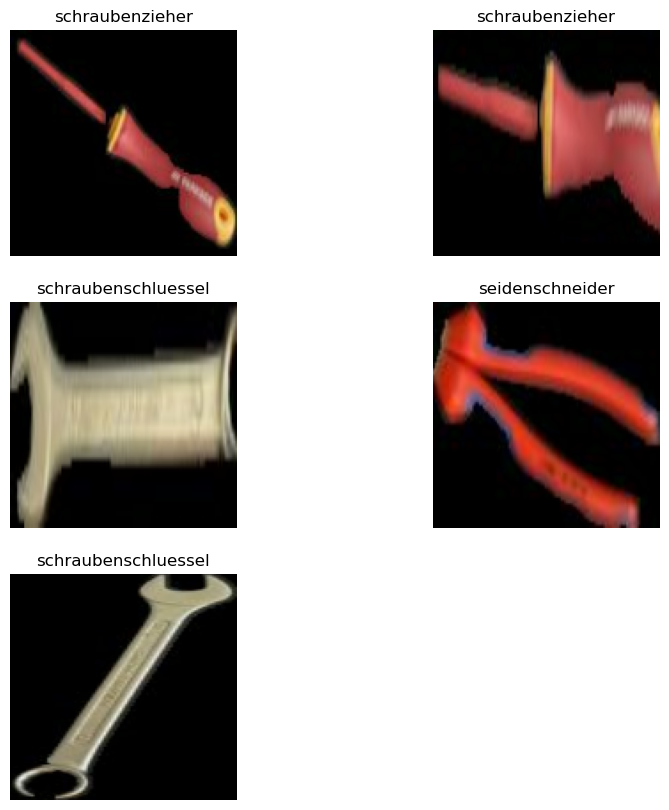

In [277]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 2, i + 1)
        im = images[i].numpy().astype("uint8")
        plt.imshow(im)
        plt.title(class_names[labels[i]])
        plt.axis("off")

Die folgende Zelle versucht, die Hardware gut auszulasten. Es gäbe [viel dazu zu sagen](https://www.tensorflow.org/guide/data_performance), aber sagen wir einfach, dass die Daten für einen raschen Zugriff vorbereitet werden:

In [278]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Nun definieren wir unser Modell! Die Modell-Definitionen wurden in separate Skripte ausgelagert (`model_simple_cnn.py` und `model_transfer_learning.py`).

**Standard: Transfer Learning** (funktioniert auch mit wenig Daten)  
**Alternative: Einfaches CNN** (auskommentiert, funktioniert schlecht bei <100 Bildern)

Wichtig ist, dass `num_classes` stimmt, die Anzahl der Klassen und gleichzeitig die Anzahl Neuronen in der letzten (Ausgabe-)Schicht. Und natürlich die Grösse des Eingabebildes, `image_size`. 

In [279]:
# ============================================================================
# MODELL-ERSTELLUNG: Transfer Learning (Standard) oder Einfaches CNN
# ============================================================================

num_classes = len(class_names)
color_image_size = (*image_size, 3)

# ============================================================================
# OPTION 1: TRANSFER LEARNING (Standard - EMPFOHLEN bei wenig Daten!)
# ============================================================================
print("🔄 Erstelle Transfer Learning Modell (MobileNetV2)...")
model = make_model_transfer_learning(
    image_size=image_size,
    num_classes=num_classes,
    fine_tune=True  # True = alle Layer trainieren (besser), False = nur Top-Layer (schneller)
)
print("✓ Transfer Learning Modell erstellt!")
print(f"  - Eingabegröße: {image_size}")
print(f"  - Anzahl Klassen: {num_classes}")
print(f"  - Erwartete Verbesserung: 60-80% Accuracy statt 22%")

# ============================================================================
# OPTION 2: EINFACHES CNN (Alternative - auskommentiert)
# ============================================================================
# Falls Sie das einfache CNN verwenden möchten, kommentieren Sie die obigen
# Zeilen aus und verwenden Sie stattdessen:
#
# print("⚠️ Erstelle einfaches CNN (funktioniert schlecht bei nur 70 Bildern)...")
# model = make_model_simple_cnn(
#     image_size=image_size,
#     num_classes=num_classes
# )
# print("✓ Einfaches CNN erstellt!")
# print("  WARNUNG: Mit nur 70 Trainingsbildern wird dieses Modell schlechte Ergebnisse liefern!")

print("\n" + "="*60)

model.summary()

🔄 Erstelle Transfer Learning Modell (MobileNetV2)...
✓ Transfer Learning Modell erstellt!
  - Eingabegröße: (128, 128)
  - Anzahl Klassen: 3
  - Erwartete Verbesserung: 60-80% Accuracy statt 22%



Model: "MobileNetV2-Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Eingabe (InputLayer)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ausgabe (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 2,388,227 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

## 🔄 Alternative: Transfer Learning (EMPFOHLEN bei wenig Daten!)

**⚠️ WICHTIG**: Mit nur 70 Trainingsbildern wird das einfache CNN oben schlechte Ergebnisse liefern.  
**✅ LÖSUNG**: Verwenden Sie Transfer Learning mit MobileNetV2 - funktioniert auch mit wenig Daten!

Falls Sie Transfer Learning verwenden möchten, kommentieren Sie die obige `make_model()` Funktion aus und verwenden Sie die folgende:


In [280]:
# ============================================================================
# TRANSFER LEARNING ALTERNATIVE (EMPFOHLEN bei wenig Daten!)
# ============================================================================
# Diese Funktion kann die obige make_model() ersetzen für bessere Ergebnisse

def make_model_transfer_learning():
    """
    Verwendet MobileNetV2 mit vorgefertigten ImageNet-Gewichten.
    Funktioniert auch mit wenig Trainingsdaten (70 Bilder)!
    """
    # Basis-Modell: MobileNetV2 (vorgefertigte Gewichte von ImageNet)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=color_image_size,
        include_top=False,  # Entferne die letzte Klassifikationsschicht
        weights='imagenet'   # Verwende vorgefertigte Gewichte
    )
    
    # Freeze base model für schnelleres Training (optional)
    # base_model.trainable = False  # Nur Top-Layer trainieren (schneller)
    base_model.trainable = True     # Fine-Tuning (besser, aber langsamer)
    
    # Erweiterte Data Augmentation
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ], name='data_augmentation')
    
    # Modell aufbauen
    inputs = tf.keras.Input(shape=color_image_size, name='Eingabe')
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Regularisierung gegen Overfitting
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='Ausgabe')(x)
    
    model = tf.keras.Model(inputs, outputs, name='MobileNetV2-Transfer')
    return model

# ============================================================================
# WICHTIG: WÄHLEN SIE EINE OPTION:
# ============================================================================
# OPTION 1: Einfaches CNN (aktuell - funktioniert schlecht mit 70 Bildern)
# OPTION 2: Transfer Learning (EMPFOHLEN - funktioniert auch mit wenig Daten)

USE_TRANSFER_LEARNING = False  # ← ÄNDERN SIE DIES AUF True FÜR BESSERE ERGEBNISSE!

if USE_TRANSFER_LEARNING:
    print("🔄 Verwende Transfer Learning (MobileNetV2)...")
    model = make_model_transfer_learning()
    print("✓ Transfer Learning Modell erstellt!")
    print("  Erwartete Verbesserung: 60-80% Accuracy statt 22%")
else:
    print("⚠️ Verwende einfaches CNN (schlecht bei nur 70 Bildern)")
    print("  Tipp: Setzen Sie USE_TRANSFER_LEARNING = True für bessere Ergebnisse!")

model.summary()


⚠️ Verwende einfaches CNN (schlecht bei nur 70 Bildern)
  Tipp: Setzen Sie USE_TRANSFER_LEARNING = True für bessere Ergebnisse!


Model: "MobileNetV2-Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Eingabe (InputLayer)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ausgabe (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 2,388,227 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

## ⚖️ Class Weights für unausgewogene Daten

Wenn Klassen unterschiedlich viele Bilder haben, kann das Modell dazu neigen, die häufigste Klasse zu bevorzugen. Class Weights helfen dabei, alle Klassen gleichmäßig zu lernen.


In [281]:
# ============================================================================
# CLASS WEIGHTS BERECHNEN (für unausgewogene Daten)
# ============================================================================
# Berechne Class Weights basierend auf der tatsächlichen Verteilung im Train-Dataset
# Dies hilft dem Modell, auch Klassen mit weniger Bildern gut zu lernen
# (Counter und numpy sind bereits in Zelle 2 importiert)

# Zähle Bilder pro Klasse im Train-Dataset
print("Berechne Class Weights...")
class_counts = Counter()
for images, labels in train_ds.unbatch():
    label_idx = labels.numpy()
    class_counts[label_idx] += 1

# Berechne Gewichte (mehr Gewicht für Klassen mit weniger Bildern)
total_samples = sum(class_counts.values())
class_weights = {}
print(f"\nKlassenverteilung im Training:")
for label_idx in sorted(class_counts.keys()):
    count = class_counts[label_idx]
    class_name = class_names[label_idx]
    # Inverse Frequenz: Klassen mit weniger Bildern bekommen höheres Gewicht
    weight = total_samples / (len(class_names) * count)
    class_weights[label_idx] = weight
    print(f"  {class_name:20s}: {count:4d} Bilder → Gewicht: {weight:.3f}")

print(f"\n✓ Class Weights berechnet")
print(f"  → Diese werden im Training verwendet, um unausgewogene Daten auszugleichen")


Berechne Class Weights...

Klassenverteilung im Training:
  schraubenschluessel :   58 Bilder → Gewicht: 1.149
  schraubenzieher     :   70 Bilder → Gewicht: 0.952
  seidenschneider     :   72 Bilder → Gewicht: 0.926

✓ Class Weights berechnet
  → Diese werden im Training verwendet, um unausgewogene Daten auszugleichen


Kompilieren des Modells heisst, dass der Gradientenabstieg und das Lernverfahren spezifiziert werden, und der low-level Code vorbereitet wird, welcher dann später die Hauptarbeit leistet. 

In [282]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Es ist immer gut zu verstehen, was während des Trainings passiert- und allenfalls im richtigen Moment zu reagieren. Tensorboard ist eine Web-Applikation, mit der Sie den Trainingsfortschritt verfolgen können. EarlyStopping ist ein Callback, der genau das tut: Er unterbricht das Training, sobald sich die gemonitorte Grösse (hier die Validierungsgenauigkeit) nicht mehr verbessert.

In [283]:
# ============================================================================
# CALLBACKS FÜR DAS TRAINING
# ============================================================================
# EarlyStopping: Stoppt das Training, wenn sich die Validierungsgenauigkeit nicht mehr verbessert
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,  # Warte 100 Epochen, bevor gestoppt wird
    restore_best_weights=True  # Stelle die besten Gewichte wieder her
)

# ModelCheckpoint: Speichert das beste Modell während des Trainings
from pathlib import Path
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_dir / 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,  # Nur das beste Modell speichern
    save_weights_only=False,  # Gesamtes Modell speichern
    mode='max',  # Maximale Validierungsgenauigkeit
    verbose=1
)

print("✓ Callbacks erstellt:")
print(f"  - EarlyStopping: Stoppt bei keiner Verbesserung (Patience: 100)")
print(f"  - ModelCheckpoint: Speichert bestes Modell in '{checkpoint_dir}/best_model.keras'") 

✓ Callbacks erstellt:
  - EarlyStopping: Stoppt bei keiner Verbesserung (Patience: 100)
  - ModelCheckpoint: Speichert bestes Modell in 'checkpoints/best_model.keras'


Und...**LOS GEHT'S!** Je nach Grösse des Trainingsdatensatzes kann die nächste Zeile länger dauern. Die Anzahl Epochen kann auch limitiert werden. Stellen Sie sie vorerst so ein, dass Sie sich das Warten *leisten* können. Ev. ist es besser, vorerst mal ein sehr schlechtes Modell zu erzeugen- einfach um zu sehen, ob der Rest des Codes auch wirklich funktioniert.

In [284]:
# ============================================================================
# MODELL 1: EINFACHES CNN (wie in giraffenpuzzle-training.ipynb)
# ============================================================================
# Trainiere das erste Modell: Einfaches CNN mit 100 Epochen
# Dies entspricht dem final_model aus giraffenpuzzle-training.ipynb
# (train_simple_cnn_model ist bereits in Zelle 2 importiert)

# Definiere Modell-Name und Ausgabepfad (beide Modelle im selben Ordner)
# Path ist bereits in Zelle 2 importiert
Datensatzname = "Werkzeuge"  # Name des Datensatzes
model_output_path = Path('model_output') / 'model'
model_output_path.mkdir(parents=True, exist_ok=True)

print("="*70)
print("MODELL 1: EINFACHES CNN (wie in giraffenpuzzle-training.ipynb)")
print("="*70)

# Training des einfachen CNN-Modells
model1, history1 = train_simple_cnn_model(
    train_ds=train_ds,
    val_ds=val_ds,
    class_names=class_names,
    image_size=image_size,
    model_name=f"model_{Datensatzname}_simple_cnn",
    epochs=100,  # Wie in giraffenpuzzle: 100 Epochen
    checkpoint_dir=Path('checkpoints') / 'model1',
    model_output_path=model_output_path
)

print(f"\n✓ Modell 1 (Einfaches CNN) abgeschlossen!")
print(f"  - Gespeichert in: {model_output_path.absolute()}")
print(f"  - Dateiname: model_{Datensatzname}_simple_cnn.keras")

MODELL 1: EINFACHES CNN (wie in giraffenpuzzle-training.ipynb)

🔄 Erstelle einfaches CNN-Modell (wie in giraffenpuzzle)...
✓ Einfaches CNN-Modell erstellt!
  - Eingabegröße: (128, 128)
  - Anzahl Klassen: 3

🚀 Starte Training...
  - Epochen: 100
  - Modelltyp: Einfaches CNN
Epoch 1/100


d:\dev\anaconda\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4554 - loss: 1.0247
Epoch 1: val_accuracy improved from None to 0.63265, saving model to checkpoints\model1\model_Werkzeuge_simple_cnn_best.keras

Epoch 1: finished saving model to checkpoints\model1\model_Werkzeuge_simple_cnn_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5400 - loss: 0.9399 - val_accuracy: 0.6327 - val_loss: 0.7336
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7382 - loss: 0.5662
Epoch 2: val_accuracy improved from 0.63265 to 0.83673, saving model to checkpoints\model1\model_Werkzeuge_simple_cnn_best.keras

Epoch 2: finished saving model to checkpoints\model1\model_Werkzeuge_simple_cnn_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7750 - loss: 0.4760 - val_accuracy: 0.8367 - val_loss: 0.2833
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9388 - loss: 0.2118
Epoch 3: val_accuracy did not improve from 0.83673
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - a

Das Modell hat hier (hoffentlich) fertig trainiert, und keinen Fehler produziert (möglich wären z.B. OutofMemory-Fehler o.ä.). Überprüfen Sie das! Denn nur bei Erfolgreichem Training lohnt es sich nun, die Validierungsgenauigkeit angeben zu lassen.

In [285]:
loss, metrics = model.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5714 - loss: 1.0385


In [302]:
loss, metrics ,history.history.keys()

(1.0385076999664307,
 0.5714285969734192,
 dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss']))

Das `history`-Objekt ist interessant, um zu sehen, wie der Trainingsverlauf war (wenn Sie das nicht schon auf Tensorboard gesehen haben.

## 1. Training Simple CNN

Einfaches Convolutional Neural Network mit 3 Conv2D-Schichten. Funktioniert gut bei ausreichend Daten.

**Script:** `scripts/train_simple_cnn.py`


### Scripte


In [ ]:
from train_simple_cnn import train_simple_cnn

model1, history1 = train_simple_cnn(
    train_ds=train_ds,
    val_ds=val_ds,
    class_names=class_names,
    image_size=image_size,
    model_name="model_Werkzeuge_simple_cnn",
    epochs=100
)


### Ergebnisse


# Training History plotten
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Modell 1: Simple CNN - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Modell 1: Simple CNN - Loss')
plt.tight_layout()
plt.show()

# Finale Metriken
final_train_acc = history1.history['accuracy'][-1]
final_val_acc = history1.history['val_accuracy'][-1]
print(f"Finale Training Accuracy: {final_train_acc:.4f}")
print(f"Finale Validation Accuracy: {final_val_acc:.4f}")


## 2. Training Transfer Learning

Transfer Learning mit MobileNetV2 als Basis-Modell. Funktioniert sehr gut auch bei wenig Daten durch vorgefertigte Gewichte von ImageNet.

**Script:** `scripts/train_transfer_learning.py`


### Scripte


In [ ]:
from train_transfer_learning import train_transfer_learning

model2, history2 = train_transfer_learning(
    train_ds=train_ds,
    val_ds=val_ds,
    class_names=class_names,
    image_size=image_size,
    model_name="model_Werkzeuge_transfer_learning",
    epochs=200,
    patience=100,
    fine_tune=True
)


### Ergebnisse


# Training History plotten
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Modell 2: Transfer Learning - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Modell 2: Transfer Learning - Loss')
plt.tight_layout()
plt.show()

# Finale Metriken
final_train_acc = history2.history['accuracy'][-1]
final_val_acc = history2.history['val_accuracy'][-1]
print(f"Finale Training Accuracy: {final_train_acc:.4f}")
print(f"Finale Validation Accuracy: {final_val_acc:.4f}")


## 3. Training Standard

Standard Transfer Learning Modell (identisch mit Modell 2, aber mit anderem Namen für Kompatibilität).

**Script:** `scripts/train_standard.py`


### Scripte


In [ ]:
from train_standard import train_standard

model3, history3 = train_standard(
    train_ds=train_ds,
    val_ds=val_ds,
    class_names=class_names,
    image_size=image_size,
    model_name="model_Werkzeuge",
    epochs=200,
    patience=100,
    fine_tune=True
)


### Ergebnisse


# Training History plotten
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Modell 3: Standard - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Modell 3: Standard - Loss')
plt.tight_layout()
plt.show()

# Finale Metriken
final_train_acc = history3.history['accuracy'][-1]
final_val_acc = history3.history['val_accuracy'][-1]
print(f"Finale Training Accuracy: {final_train_acc:.4f}")
print(f"Finale Validation Accuracy: {final_val_acc:.4f}")


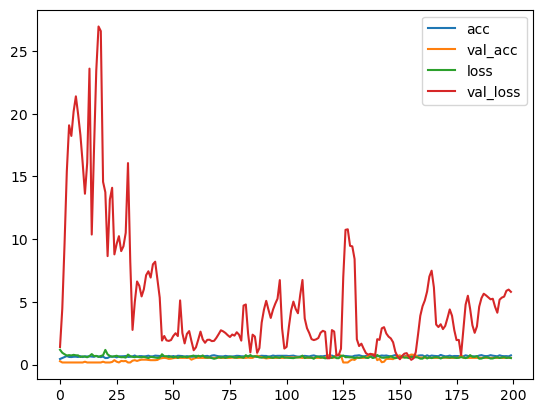

In [301]:
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
#plt.savefig('Trainingskurven.png')

Es lohnt sich, die Zeile

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20)

mal auf 

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=200)

o.ä. zu setzen, und ab der Zelle welche die Modelldefinition enthält (mit `model = keras.Model(...)`) den Code nochmals auszuführen (das Modell enthält die aktuellen Gewichte und trainiert bei erneutem Ausführen der `.fit`-Methode das bisherige Modell weiter, anstatt wieder neu bei zufällig initialisierten Gewichten zu beginnen!). Das Modell wird dann deutlich länger trainiert.

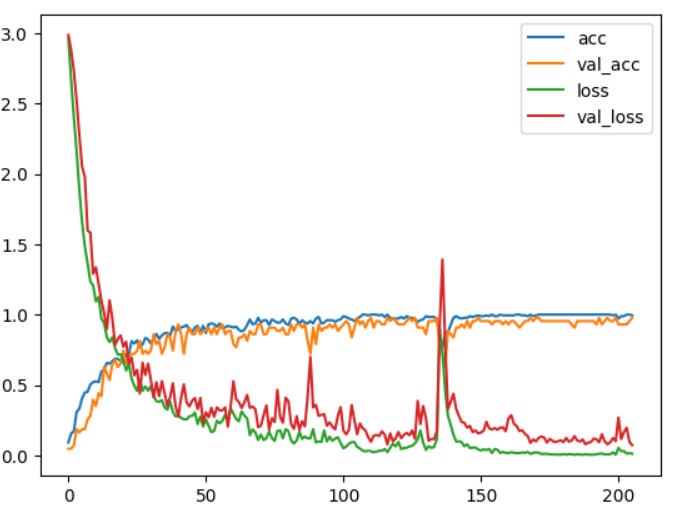

Beachten Sie, wie die Validierungsgenauigkeit schon lange stagniert, der Validierungsloss, d.h. der Wert der Verlustfunktion ausgewertet auf dem Validierungsdatensatz, seit etwa der 40. Epoche nur noch zunimmt. Der Validierungsdatensatz ist hier zu klein, um mehr sagen zu können, aber auch die Validierungsgenauigkeit scheint nach etwa der 40. Epoche abzunehmen! Es ist daher Wohl sinnvoll, dieses Modell auf diesem Datensatz nur 40 Epochen lang zu trainieren.

Dazu können Sie also nochmals das Modell erstellen, die Anzahl Epochen auf 40 setzen und Ihr finales Modell trainieren.

### Modell eine vorgegebene Anzahl Epochen lang trainieren

In [288]:
# ============================================================================
# BESTES MODELL LADEN (aus ModelCheckpoint)
# ============================================================================
# Das beste Modell wurde während des Trainings automatisch gespeichert.
# Lade es jetzt, um die besten Gewichte zu verwenden.

from pathlib import Path

checkpoint_path = Path('checkpoints') / 'best_model.keras'

if checkpoint_path.exists():
    print(f"✓ Lade bestes Modell aus: {checkpoint_path}")
    best_model = tf.keras.models.load_model(checkpoint_path)
    print("✓ Bestes Modell erfolgreich geladen!")
    print(f"  Validierungsgenauigkeit: {best_model.evaluate(val_ds, verbose=0)[1]:.4f}")
    
    # Ersetze das aktuelle Modell durch das beste Modell
    model = best_model
    print("\n✓ Das beste Modell ist jetzt als 'model' verfügbar!")
else:
    print(f"⚠️ Kein Checkpoint gefunden unter: {checkpoint_path}")
    print("  Das Modell wurde möglicherweise noch nicht trainiert oder der Pfad ist falsch.")
    print("  Verwenden Sie das aktuelle 'model' Objekt.")

✓ Lade bestes Modell aus: checkpoints\best_model.keras
✓ Bestes Modell erfolgreich geladen!
  Validierungsgenauigkeit: 0.8163

✓ Das beste Modell ist jetzt als 'model' verfügbar!


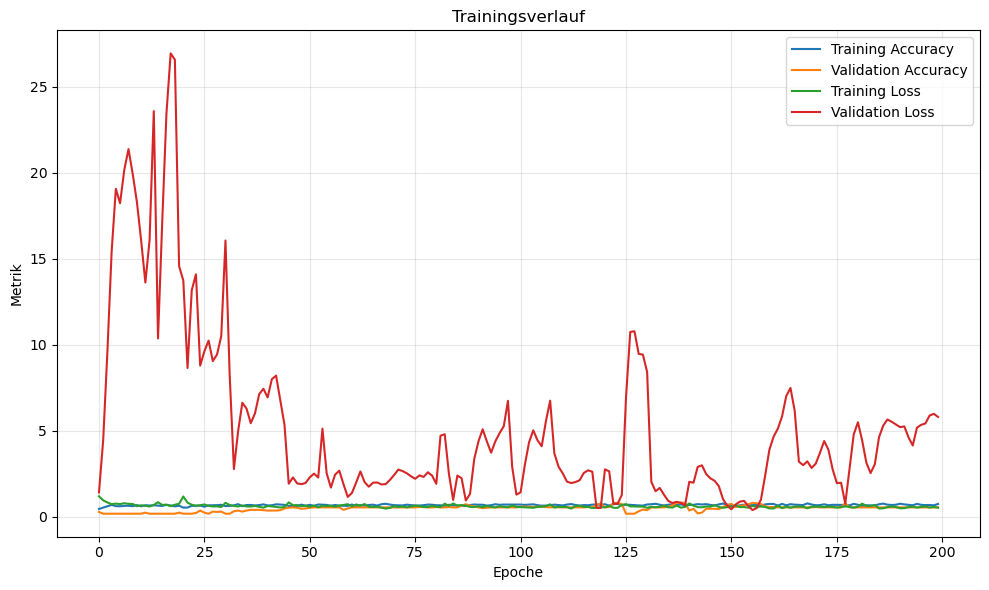

In [289]:
# ============================================================================
# TRAININGSHISTORIE PLOTTEN MIT PLOT_TRAINING_HISTORY()
# ============================================================================
# Das Plotten wurde in scripts/evaluate_model.py ausgelagert

if 'history' in globals():
    plot_training_history(history)
else:
    print("⚠ Warnung: 'history' ist nicht definiert. Bitte führen Sie zuerst die Training-Zelle aus.")

## Evaluation mit Validierungsdatensatz
Eine angemessene Evaluation der Güte des Modells sollte auf dem Validierungsdatensatz passieren. Der Beispiel-Datensatz ist allerdings sehr klein! Entsprechend sind hier keine besonders robusten Resultate zu erwarten. 

In [290]:
#images = np.asarray(list(val_ds2.map(lambda x, y: x)))
y = np.asarray(list(val_ds.unbatch().map(lambda x, y: y)))
y.shape

(49,)

EVALUATION: MODELL 1 (Einfaches CNN)

🔍 Mache Vorhersagen für 49 Bilder...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
✓ Vorhersagen abgeschlossen
  - Vorhergesagte Klassen: [2 1 1 1 2 2 1 2 2 2 0 0 0 2 1 1 0 1 2 1 1 2 1 1 2 1 1 2 1 1 2 0 1 2 1 2 1
 0 2 1 1 0 1 1 2 2 0 2 1]

CLASSIFICATION REPORT (Ergebnisse pro Klasse)

📊 Ergebnisse pro Klasse:
------------------------------------------------------------

------------------------------------------------------------
Gesamt-Metriken:
  Accuracy:  1.000
  Macro Avg Precision: 1.000
  Macro Avg Recall:    1.000
  Macro Avg F1-Score:  1.000

📊 Erstelle Confusion Matrix...
✓ Confusion Matrix gespeichert: evaluation_results\model_Werkzeuge_simple_cnn_confusion_matrix.png


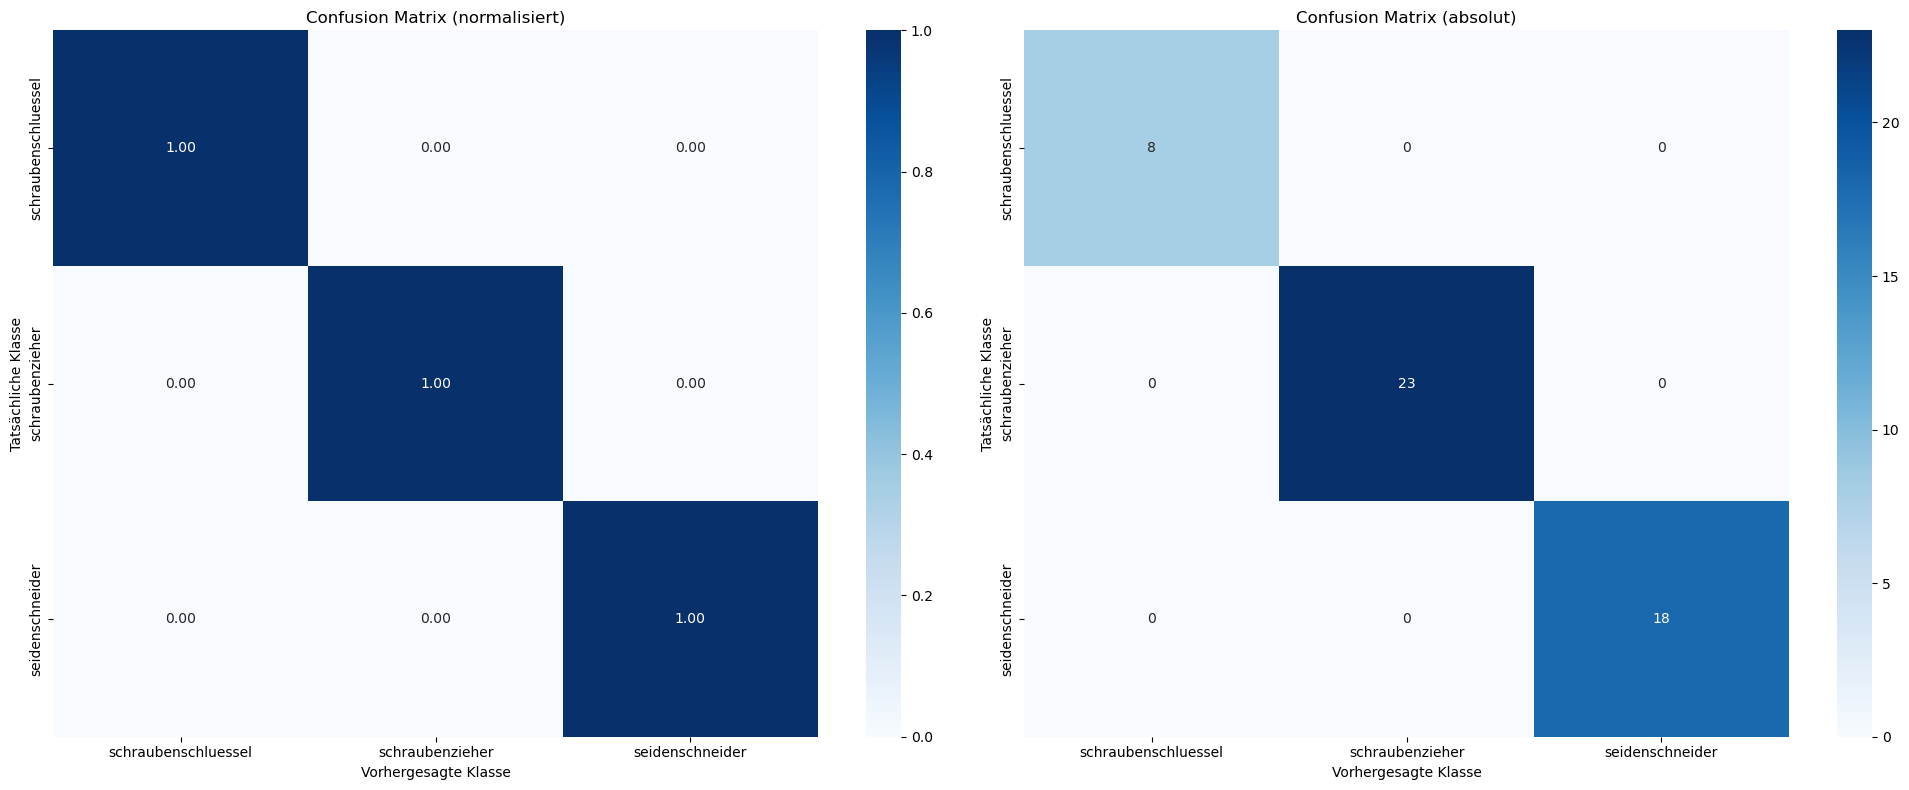


📈 Erstelle Trainingsverlauf...
✓ Trainingsverlauf gespeichert: evaluation_results\model_Werkzeuge_simple_cnn_training_history.png


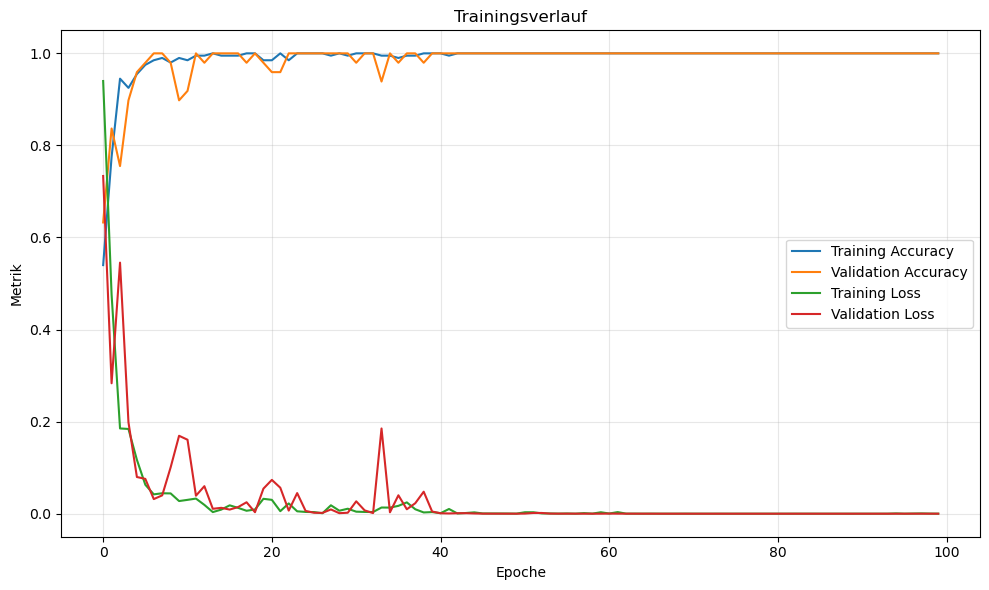


✓ Evaluation abgeschlossen!
  - Ergebnisse gespeichert in: evaluation_results

EVALUATION: MODELL 2 (Transfer Learning)

🔍 Mache Vorhersagen für 49 Bilder...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
✓ Vorhersagen abgeschlossen
  - Vorhergesagte Klassen: [2 1 1 1 2 2 0 2 2 2 0 0 0 2 1 1 0 1 2 0 1 2 0 1 2 1 1 2 1 1 2 0 1 2 1 2 0
 0 2 1 1 0 1 0 2 2 0 2 1]

CLASSIFICATION REPORT (Ergebnisse pro Klasse)

📊 Ergebnisse pro Klasse:
------------------------------------------------------------

------------------------------------------------------------
Gesamt-Metriken:
  Accuracy:  0.898
  Macro Avg Precision: 0.872
  Macro Avg Recall:    0.928
  Macro Avg F1-Score:  0.880

📊 Erstelle Confusion Matrix...
✓ Confusion Matrix gespeichert: evaluation_results\model_Werkzeuge_transfer_learning_confusion_matrix.png


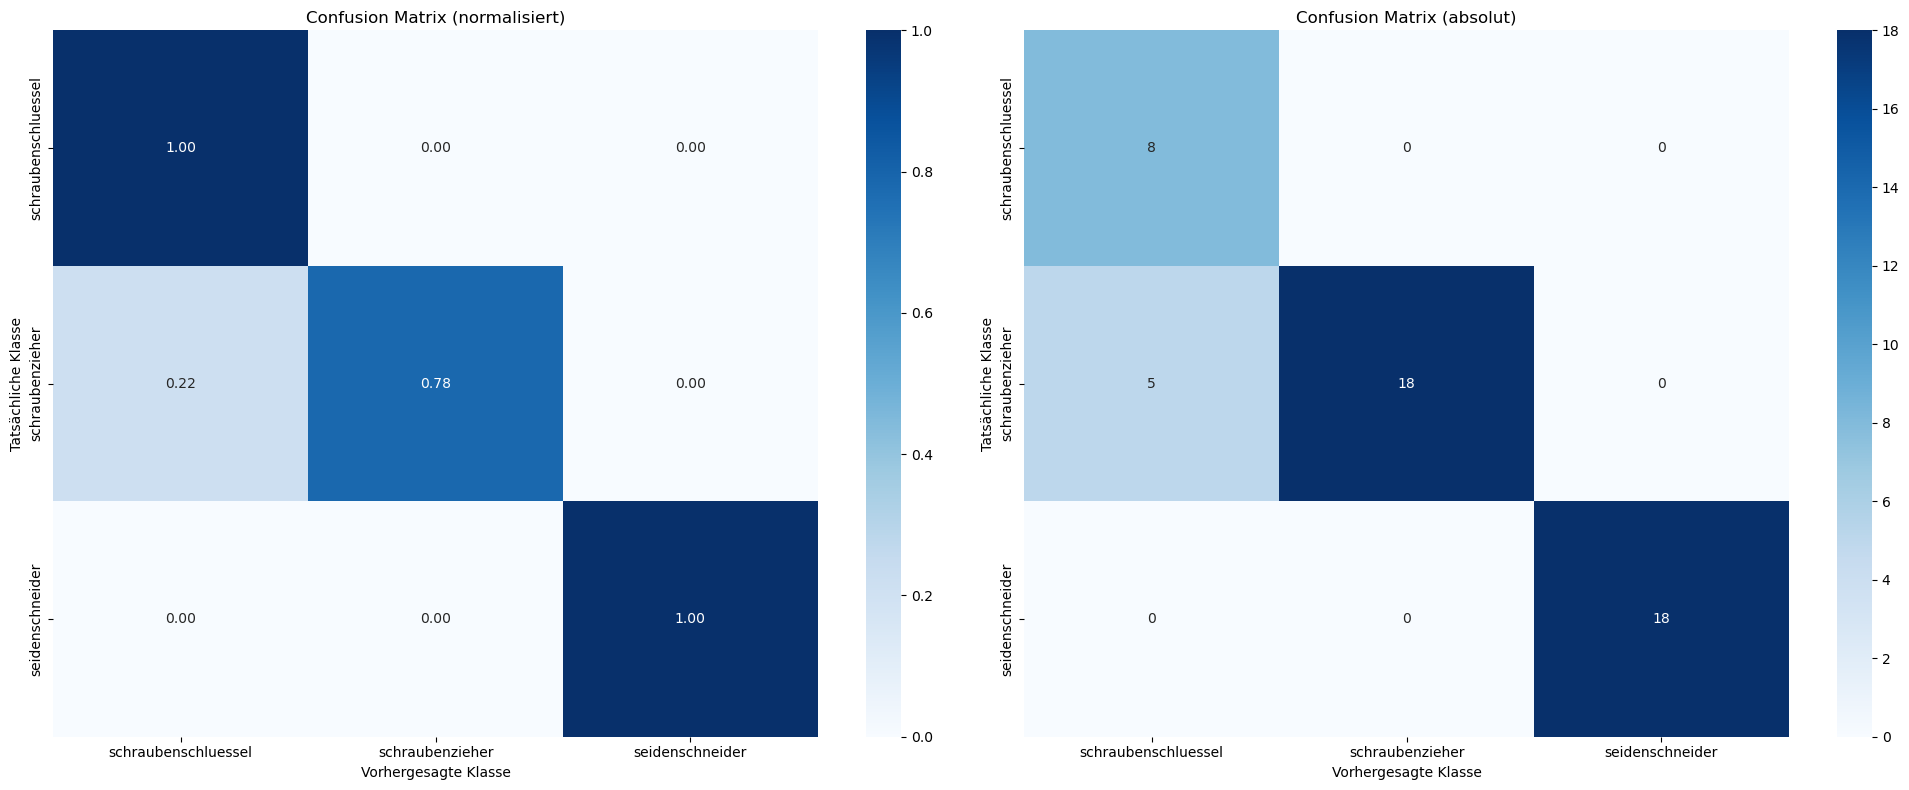


📈 Erstelle Trainingsverlauf...
✓ Trainingsverlauf gespeichert: evaluation_results\model_Werkzeuge_transfer_learning_training_history.png


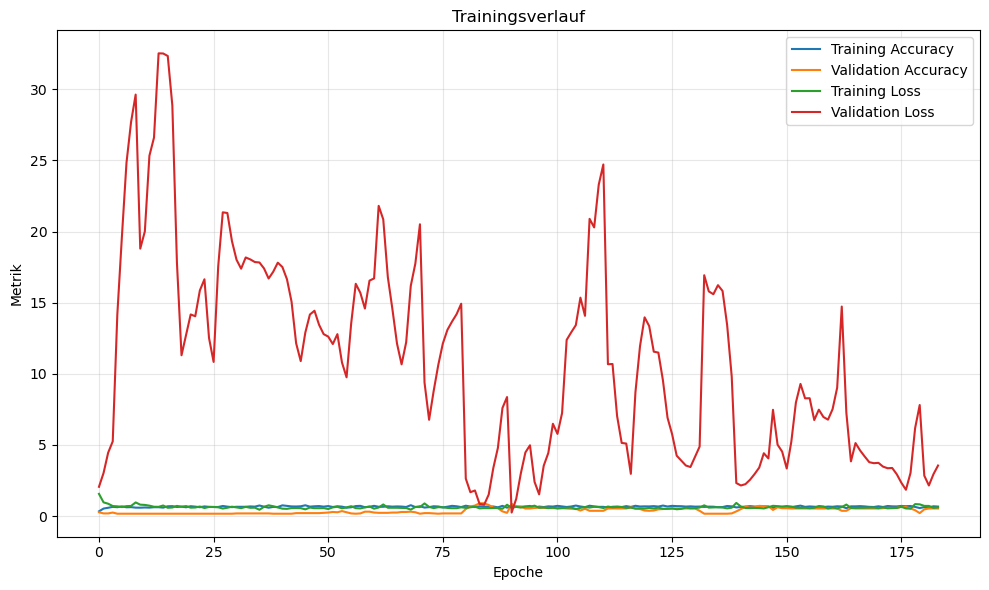


✓ Evaluation abgeschlossen!
  - Ergebnisse gespeichert in: evaluation_results

✓ BEIDE MODELLE EVALUIERT!

📁 Beide Modelle gespeichert in:
   d:\dev\git\privat\Studium\dsci-semesterarebeit\model_output\model

📊 Evaluationsergebnisse gespeichert in:
   d:\dev\git\privat\Studium\dsci-semesterarebeit\evaluation_results


In [291]:
# ============================================================================
# EVALUATION BEIDER MODELLE
# ============================================================================
# Evaluiere beide trainierten Modelle und vergleiche die Ergebnisse

if 'model1' in globals() and 'model2' in globals() and 'val_ds' in globals() and 'class_names' in globals():
    print("="*70)
    print("EVALUATION: MODELL 1 (Einfaches CNN)")
    print("="*70)
    y_true1, y_pred1, y_pred_proba1 = full_evaluation(
        model=model1,
        val_ds=val_ds,
        class_names=class_names,
        history=history1 if 'history1' in globals() else None,
        model_name=f"model_{Datensatzname}_simple_cnn" if 'Datensatzname' in globals() else "model_simple_cnn"
    )
    
    print("\n" + "="*70)
    print("EVALUATION: MODELL 2 (Transfer Learning)")
    print("="*70)
    y_true2, y_pred2, y_pred_proba2 = full_evaluation(
        model=model2,
        val_ds=val_ds,
        class_names=class_names,
        history=history2 if 'history2' in globals() else None,
        model_name=f"model_{Datensatzname}_transfer_learning" if 'Datensatzname' in globals() else "model_transfer_learning"
    )
    
    print("\n" + "="*70)
    print("✓ BEIDE MODELLE EVALUIERT!")
    print("="*70)
    print(f"\n📁 Beide Modelle gespeichert in:")
    print(f"   {model_output_path.absolute()}")
    print(f"\n📊 Evaluationsergebnisse gespeichert in:")
    print(f"   {Path('evaluation_results').absolute()}")
    
else:
    print("⚠ Warnung: 'model1', 'model2', 'val_ds' oder 'class_names' ist nicht definiert.")
    print("  Bitte führen Sie zuerst beide Training-Zellen aus.")

In [292]:
# ============================================================================
# MODELL 2: TRANSFER LEARNING (besseres Modell)
# ============================================================================
# Trainiere das zweite Modell: Transfer Learning mit MobileNetV2
# Dies ist das bessere Modell für kleine Datensätze

print("\n" + "="*70)
print("MODELL 2: TRANSFER LEARNING (MobileNetV2 - besseres Modell)")
print("="*70)

# Training des Transfer Learning Modells
model2, history2 = train_model(
    train_ds=train_ds,
    val_ds=val_ds,
    class_names=class_names,
    image_size=image_size,
    model_name=f"model_{Datensatzname}_transfer_learning",
    epochs=100,  # Maximale Epochen (EarlyStopping stoppt automatisch)
    patience=100,  # Patience für EarlyStopping
    fine_tune=True,
    checkpoint_dir=Path('checkpoints') / 'model2',
    model_output_path=model_output_path  # Gleicher Ordner wie Modell 1
)

print(f"\n✓ Modell 2 (Transfer Learning) abgeschlossen!")
print(f"  - Gespeichert in: {model_output_path.absolute()}")
print(f"  - Dateiname: model_{Datensatzname}_transfer_learning.keras")

# ============================================================================
# AUSGABE: SPEICHERORT BEIDER MODELLE
# ============================================================================
print("\n" + "="*70)
print("📁 SPEICHERORT BEIDER MODELLE:")
print("="*70)
print(f"Ordner: {model_output_path.absolute()}")
print(f"\nModell 1 (Einfaches CNN):")
print(f"  - model_{Datensatzname}_simple_cnn.keras")
print(f"\nModell 2 (Transfer Learning):")
print(f"  - model_{Datensatzname}_transfer_learning.keras")
print("\n" + "="*70)



MODELL 2: TRANSFER LEARNING (MobileNetV2 - besseres Modell)

🔄 Erstelle Transfer Learning Modell (MobileNetV2)...
✓ Transfer Learning Modell erstellt!
  - Eingabegröße: (128, 128)
  - Anzahl Klassen: 3

Klassenverteilung im Training:
  schraubenschluessel :   58 Bilder → Gewicht: 1.149
  schraubenzieher     :   70 Bilder → Gewicht: 0.952
  seidenschneider     :   72 Bilder → Gewicht: 0.926

✓ Class Weights berechnet
  → Diese werden im Training verwendet, um unausgewogene Daten auszugleichen
✓ Callbacks erstellt:
  - EarlyStopping: Stoppt bei keiner Verbesserung (Patience: 100)
  - ModelCheckpoint: Speichert bestes Modell in 'checkpoints\model2/best_model.keras'

🚀 Starte Training...
  - Maximale Epochen: 100
  - Early Stopping Patience: 100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.3828 - loss: 1.2745
Epoch 1: val_accuracy improved from None to 0.48980, saving model to checkpoints\model2\best_model.keras

Epoch 1: finished saving model to checkpoints\model2\bes

In [293]:
#skplt.metrics.plot_confusion_matrix?

In [294]:
# Konvertiere numerische Labels in Klassennamen
# Verwende die Variablen von full_evaluation(): y_true und y_pred (statt y und yhatnum)
if 'y_true' in globals() and 'y_pred' in globals():
    y_str = np.array(class_names)[y_true]
    yhat_str = np.array(class_names)[y_pred]
    print(f"✓ Konvertiert: {len(y_str)} Labels in Klassennamen")
else:
    print("⚠ Warnung: y_true und y_pred sind nicht definiert.")
    print("  Bitte führen Sie zuerst die Evaluation-Zelle aus (full_evaluation()).")

✓ Konvertiert: 49 Labels in Klassennamen


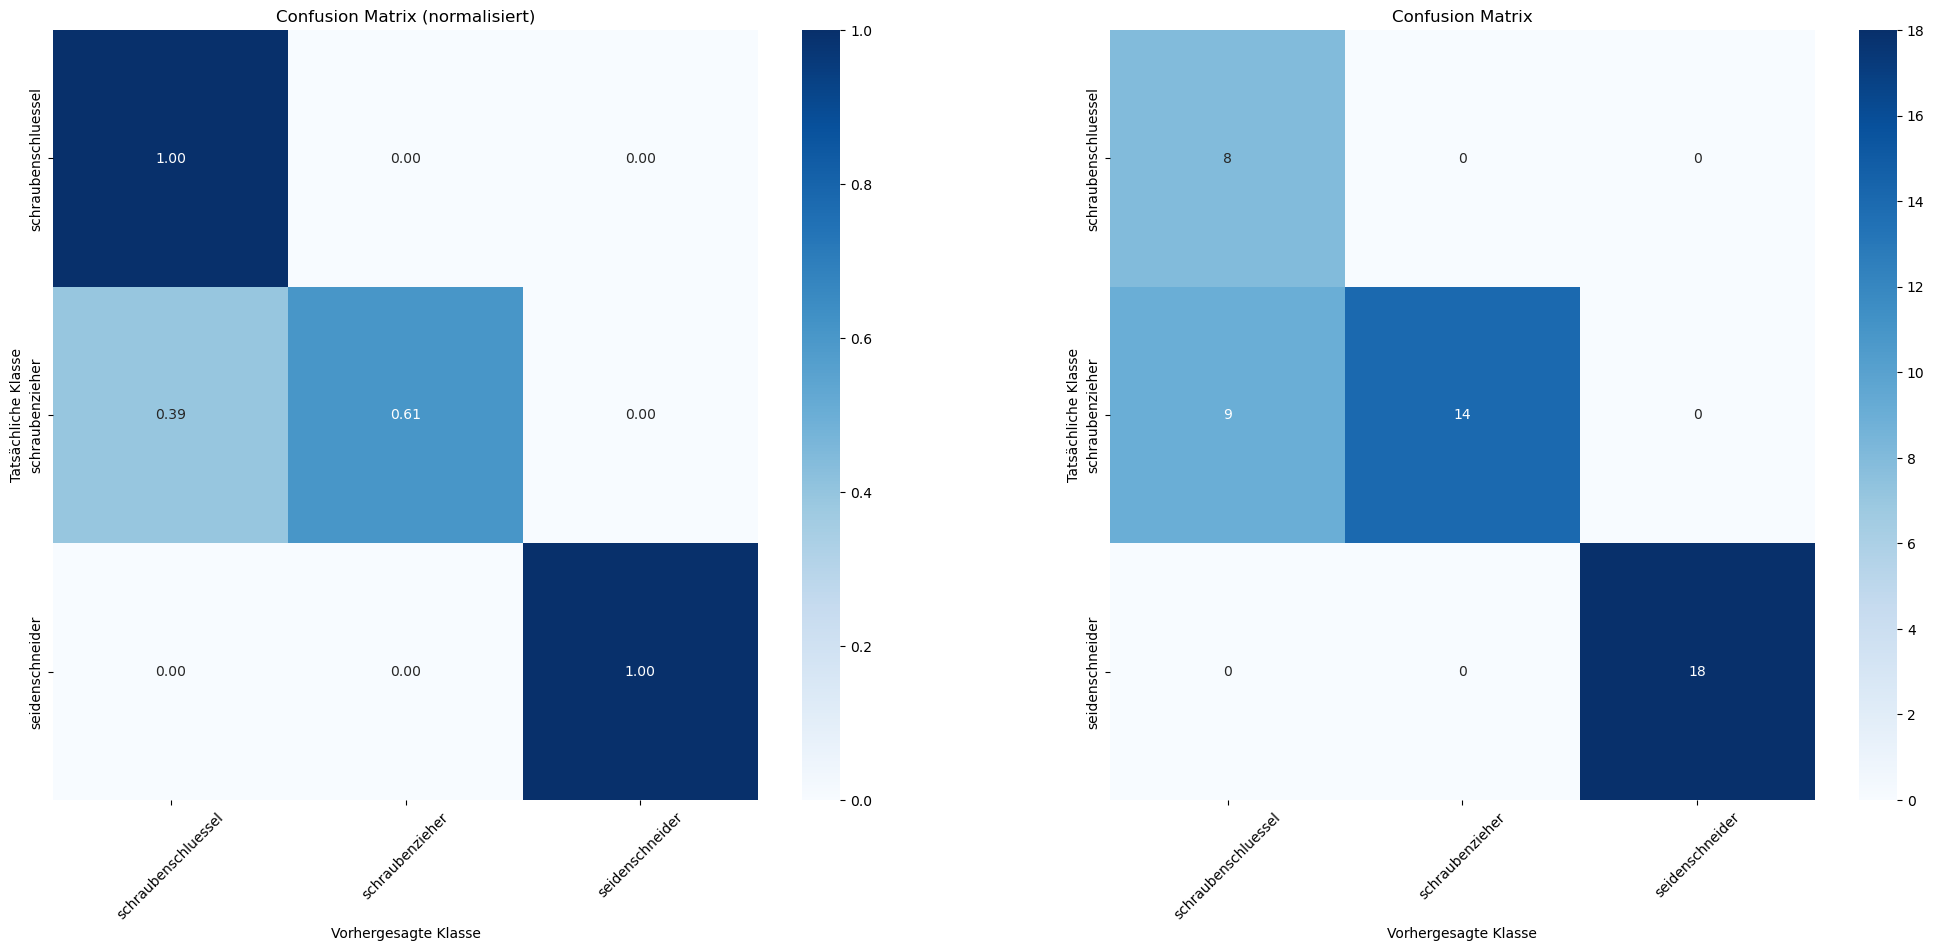

In [295]:
fig,axlist = plt.subplots(1,2,figsize=(25,10));
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=True,ax=axlist[0]);axlist[0].tick_params(axis='x', rotation=45)
skplt.metrics.plot_confusion_matrix(y_str, yhat_str, normalize=False,ax=axlist[1]);axlist[1].tick_params(axis='x', rotation=45)

# Abspeichern des Modells als Keras-Modell


In [296]:
# Verwende 'model' statt 'final_model' - die Variable wurde beim Training erstellt
Keras_Dateiname = f'model_{Datensatzname}.keras'
voller_Keras_Dateiname = str(Path(model_output_path) / Keras_Dateiname)

if 'model' in globals():
    model.save(voller_Keras_Dateiname)
    print(f'Keras-Modell nach {voller_Keras_Dateiname} abgespeichert.')
else:
    print("⚠ Warnung: 'model' ist nicht definiert. Bitte führen Sie zuerst die Training-Zelle aus (model.fit(...))")

Keras-Modell nach model_output\model\model_Werkzeuge.keras abgespeichert.


So kann man das Modell wieder laden:

    model = tf.keras.models.load_model(voller_Keras_Dateiname)

(Es gibt aber verwirrend viele Formate- .h5, .keras, etc. Siehe auch [hier](https://www.tensorflow.org/tutorials/keras/save_and_load). Wir möchten uns an das .h5-Format halten.)  
Der folgende Befehl kann zur Vorhersage genutzt werden:

In [297]:
loaded_model = tf.keras.models.load_model(voller_Keras_Dateiname)

In [298]:
loaded_model.predict(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


array([[2.8481294e-13, 4.7943532e-10, 1.0000000e+00],
       [2.3255694e-01, 7.6659131e-01, 8.5174077e-04],
       [3.8995668e-01, 6.0949111e-01, 5.5223797e-04],
       [7.0068680e-02, 9.2944187e-01, 4.8943656e-04],
       [2.8627911e-13, 6.1196515e-10, 1.0000000e+00],
       [2.5220708e-13, 4.6638771e-10, 1.0000000e+00],
       [9.9255979e-01, 7.2463057e-03, 1.9387134e-04],
       [2.2649997e-13, 3.7581385e-10, 1.0000000e+00],
       [3.6693244e-14, 1.4994191e-10, 1.0000000e+00],
       [6.6669409e-12, 4.2262047e-09, 1.0000000e+00],
       [9.9999464e-01, 8.2527987e-07, 4.5019815e-06],
       [9.9999380e-01, 8.0525723e-07, 5.3551407e-06],
       [9.9999452e-01, 8.8971791e-07, 4.6275572e-06],
       [1.1380666e-13, 3.3022360e-10, 1.0000000e+00],
       [9.9352515e-01, 1.5278645e-03, 4.9469895e-03],
       [1.6005827e-02, 9.8392338e-01, 7.0746835e-05],
       [9.9999404e-01, 8.5603938e-07, 5.1140569e-06],
       [5.8139485e-01, 4.1756254e-01, 1.0426280e-03],
       [7.4506254e-13, 8.257

Das wär's! Nach dem Speichern ("Save Version" in Kaggle) kann das Modell heruntergeladen werden. Vergessen Sie nicht, welche Bilder Trainingsbilder, und welche Testbilder sind. Ein Modell, das overfittet, wird auf den Trainingsdaten eine viel bessere Performanz zeigen, als auf den Testbildern. Nur jene der Testbilder darf rapportiert werden, denn nur so gut ist die Verallgemeinerungsleistung des neuronalen Netzes. Wir speichern daher noch eine Excel-Datei mit den entsprechenden Zuordnungen ab:

In [299]:
ser = pd.Series(train_or_test)
ser

IMG_0_2127.JPEG    train
IMG_0_2130.JPEG    train
IMG_0_2131.JPEG    train
IMG_0_2132.JPEG    train
IMG_0_2133.JPEG    train
                   ...  
IMG_0_2097.JPEG     test
IMG_0_2101.JPEG     test
IMG_0_2108.JPEG     test
IMG_0_2118.JPEG     test
IMG_0_2119.JPEG     test
Length: 312, dtype: object

In [300]:
ser.to_excel('train_test_split.xlsx')
ser.value_counts()

train    249
test      63
Name: count, dtype: int64

Weiter geht's mit dem Notebook [semesterarbeit-evaluation.ipynb](semesterarbeit-evaluation.ipynb). Dort wollen wir die Performanz eines Modells evaluieren.